<a href="https://colab.research.google.com/github/Annah998936/CSE547-Machine-Learning-Big-Data/blob/main/CSE_547_Colab_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CSE 547 - Colab 9
#Causal Inference

# Set up

Let's authenticate a Google Drive client to download the file we will be processing.

**Make sure to follow the interactive instructions.**

In [34]:
!pip install -U -q PyDrive

In [35]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [36]:
id='1aJo6O3S5BBVT7QufADkejDGBkg0eY53R'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('running.csv')

If you executed the cells above, you should be able to see the dataset we will use for this Colab under the "Files" tab on the left panel.

Next, we import some of the common libraries for our task.

In [37]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.neighbors import NearestNeighbors

# Your Task

In this colab, you will work on a fictitious data that aims to demonstrate some of the common challenges and mistakes in estimating the Average Treatment Effects (ATE). Below is the description of the fictitious data:

*SuperShoes* Company recently released a new product named *Lightning Shoes*, and claimed that wearing the shoes will significantly speed up how fast a person can run. A skeptical researcher decided to conduct a study to test the credibility of this claim. To do this, he recruited 20,000 people who may or may not have bought the lightning shoes, and asked them to record how many meters they can sprint in one minute. For those who have bought the lightning shoes, they would need to wear the shoes to do the test run. The researcher also collected a variety of data on the participants' demographic and health-related information. The final sample the researcher obtained is the  **running.csv** dataset, with the following variables:

*   **speed**: number of meters the participant runs in a minute.
*   **lightning**: whether the participant wore the lightning shoes for the run. 1 = yes, 0 = no.
*   **age**: age of the participant.
*   **gender**: 1 = male, 0 = female.
*   **veg**: 1 = vegetarian, 0 = non-vegetarian.
*   **exercise**: exercise level on a scale of [1, 10]
*   **muscle**: muscle level on a scale of [1, 10]
*  **stress**: stress level on a scale of [1, 10]
*   **heart**: heart rate that is recorded after the 1 minute run.

We are interested in estimating the treatment effect of wearing the lightning shoes (i.e. the cause) on the speed people can run (i.e. the outcome).


# Data Overview

In [38]:
# load the data
df = pd.read_csv("running.csv")

In [39]:
# have a view on the data
df.describe()

,speed,lightning,age,gender,veg,exercise,muscle,stress,heart
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000
mean,300.318442,0.614750,36.503737,0.496950,0.78035,4.995104,4.957283,4.979354,109.458008
std,20.880921,0.486666,16.451748,0.500003,0.41402,2.893961,2.898828,2.888570,7.591382
min,241.601760,0.000000,8.000517,0.000000,0.00000,0.000282,0.000086,0.000014,87.960925
25%,284.695421,0.000000,22.404614,0.000000,1.00000,2.482666,2.418058,2.482338,103.777345
50%,300.321720,1.000000,36.385972,0.000000,1.00000,4.993835,4.949709,4.965682,109.462160
75%,315.880099,1.000000,50.703279,1.000000,1.00000,7.506822,7.471355,7.479032,115.135019
max,361.686005,1.000000,64.994626,1.000000,1.00000,9.999747,9.999733,9.999641,131.888903


## Q1: Calculate the unadjusted ATE.  

First, calculate the difference in the average speed between people who wear the lightning shoes (i.e. treatment group) and people do not (i.e. control group). Let's call this the unadjusted ATE. **Report the unadjusted ATE rounded to 3 decimal places.**   


In [40]:
# YOUR CODE HERE

# Separate the groups
treatment_group = df[df['lightning'] == 1]
control_group = df[df['lightning'] == 0]

# Calculate the average speed for each group
average_speed_treatment = treatment_group['speed'].mean()
average_speed_control = control_group['speed'].mean()

# Compute the unadjusted ATE
unadjusted_ATE = average_speed_treatment - average_speed_control
unadjusted_ATE

-0.8761375557055544

We can obtain the same result by running a simple linear regression where the independent variable is the treatment status (i.e. whether the participant wears the lightning shoes or not), and the outcome variable is the speed of running. The **OLS_estimate()** below uses the [statsmodels API](https://www.statsmodels.org/stable/index.html) to perform the linear regressions. Check whether the coefficient on lightning is the same as what you have obtained in Q1.

In [41]:
def OLS_estimate(outcome, covariates):
    covariates = sm.add_constant(covariates) # adding a constant
    model = OLS(outcome, covariates)
    result = model.fit()
    print(result.summary())

OLS_estimate(df['speed'], df[['lightning']])

                            OLS Regression Results                            
Dep. Variable:                  speed   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     8.342
Date:                Thu, 23 May 2024   Prob (F-statistic):            0.00388
Time:                        19:08:41   Log-Likelihood:                -89151.
No. Observations:               20000   AIC:                         1.783e+05
Df Residuals:                   19998   BIC:                         1.783e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        300.8570      0.238   1264.959      0.0

The result so far shows that there is a statistically significant yet relatively small effect of wearing the shoes, but the unadjusted ATE is negative, suggesting the shoes make you slower! However, this result is most likely biased. In fact, the true effect is known to be 10. What has gone wrong?

The main problem here is that people who choose to obtain the shoes are different from people who choose not to obtain the lightning shoes. This is called the **selection bias**, where people *select themselves into the treatment group* due to some other factors that also affect how fast they can run. Those factors are called the **confounders**. To see this, let's calculate the sample averages of the covariates between the two groups.   



In [42]:
df.groupby('lightning')[['exercise', 'age', 'stress', 'gender', 'muscle', 'veg', 'heart']].agg(['mean'])


,exercise,age,stress,gender,muscle,veg,heart
,mean,mean,mean,mean,mean,mean,mean
lightning,,,,,,,
0,5.925047,27.192573,4.964066,0.491629,5.609706,0.812589,109.402687
1,4.412330,42.338834,4.988935,0.500285,4.548425,0.760146,109.492677


This shows that people in the treatment group are on average older, exercise less, and have less muscle. In the next section, we control for those variables and see how they change our estimates.  

# Linear Regressions

In this section, run a set of linear regressions using the **OLS_estimate()** function, with the following additional covariates besides the lightning variable:

*   Specification 1 (S1): exercise, age, gender, veg.
*   Specification 2 (S2): include all variables.
*   Specification 3 (S3): exercise, age, gender, stress, muscle.


## Q2: What are the estimated ATEs from these three specifications?

In [43]:
# YOUR CODE HERE

def OLS_estimate(outcome, covariates):
    covariates = sm.add_constant(covariates) # adding a constant
    model = OLS(outcome, covariates)
    result = model.fit()
    print(result.summary())

OLS_estimate(df['speed'], df[['lightning', 'exercise', 'age', 'gender', 'veg']])

                            OLS Regression Results                            
Dep. Variable:                  speed   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     793.3
Date:                Thu, 23 May 2024   Prob (F-statistic):               0.00
Time:                        19:08:41   Log-Likelihood:                -87345.
No. Observations:               20000   AIC:                         1.747e+05
Df Residuals:                   19994   BIC:                         1.747e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        281.2140      0.514    546.888      0.0

In [44]:
OLS_estimate(df['speed'], df[['lightning', 'exercise', 'age', 'gender', 'veg', 'stress', 'muscle', 'heart']])

                            OLS Regression Results                            
Dep. Variable:                  speed   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.774e+08
Date:                Thu, 23 May 2024   Prob (F-statistic):               0.00
Time:                        19:08:41   Log-Likelihood:                 22548.
No. Observations:               20000   AIC:                        -4.508e+04
Df Residuals:                   19991   BIC:                        -4.501e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        183.2590      1.048    174.897      0.0

In [45]:
OLS_estimate(df['speed'], df[['lightning', 'exercise', 'age', 'gender', 'stress', 'muscle']])

                            OLS Regression Results                            
Dep. Variable:                  speed   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.459e+08
Date:                Thu, 23 May 2024   Prob (F-statistic):               0.00
Time:                        19:08:41   Log-Likelihood:                 17717.
No. Observations:               20000   AIC:                        -3.542e+04
Df Residuals:                   19993   BIC:                        -3.537e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        300.0022      0.003   1.03e+05      0.0

As you can see from the results, apart from S3, which is our true model, S1 and S2 both severely under-estimate the true effect of 10, *even though the coefficeints are both statiscally significant (i.e. with extremely small p-value)*. This demonstrates the fact that even if the estimates are statistically significant and the R-squared score is nearly perfect, as in this case, it does not indicate we have obtained the unbiased estimates.


This also demonstrates that including more variables do not necessarily reduce our biases. In S1, the result is under-estimated because we fail to control for some of the confounders such as stress and muscle. However, controlling for too many variables, such as in S2, is also wrong. What happened in S2 is that we have a **collider** in the data, where the heart rate is affected by both the outcome (i.e. speed) and the treatment variable (i.e. lightning). Controlling for the collider would lead to distorted associations between the treatment and outcome. For more details on this problem, see [collider](https://en.wikipedia.org/wiki/Collider_(statistics))).



# Propensity Score Matching




One method to tackle the problem is **propensity score matching (PSM)**. The idea is to reduce the biases by comparing outcomes between the treated and control subjects who have similar propensity to be treated (i.e. propensity scores). In this section, you will implement three types of matching: **(1) nearest-neighbor matching (2) stratification matching, and (3) inverse probability weighting (IPW) matching**.




The **gen_pscore()** function generates the propensity scores by performing a logistic regression. It also plots the distributions of generated propensity scores across the groups. We will use this function to generate the propensity scores using exercise, age, stress, gender, muscle and veg as covariates.

Optimization terminated successfully.
         Current function value: 0.494720
         Iterations 6


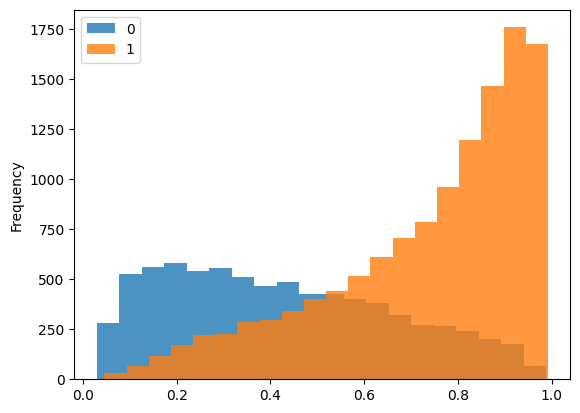

In [46]:
def gen_pscore(data, outcome, covariates):
    model = sm.Logit(outcome, covariates)
    result = model.fit()
    data['pscore'] = result.predict(covariates)
    data.groupby(['lightning']).pscore.plot(kind='hist', bins=20, alpha=0.8, legend=True)

gen_pscore(df, df['lightning'], df[[ 'exercise', 'age', 'stress', 'gender', 'muscle', 'veg']] )

The table below summarizes the distribution of the propensity scores for the two groups respectively.

In [47]:
df.groupby(['lightning']).pscore.describe()

,count,mean,std,min,25%,50%,75%,max
lightning,,,,,,,,
0,7705.0,0.423451,0.240459,0.030010,0.218609,0.390982,0.605314,0.987674
1,12295.0,0.733850,0.215281,0.045984,0.610093,0.800415,0.908284,0.991530


Notice that some scores lie outside of the common ranges. The **trim()** function below trims the sample such that the treatment and control group share the common support.


In [48]:
def trim(data):
  control_data = data[data.lightning == 0]
  treat_data = data[data.lightning == 1]

  min_control, min_treat = control_data.pscore.min(), treat_data.pscore.min()
  max_control, max_treat = control_data.pscore.max(), treat_data.pscore.max()

  min_support = max(min_control, min_treat)
  max_support = min(max_control, max_treat)

  trim_data = data.loc[((data.pscore >= min_support) & (data.pscore <= max_support)),:]

  return trim_data

trim_df = trim(df)
trim_df.groupby(['lightning']).pscore.describe()

,count,mean,std,min,25%,50%,75%,max
lightning,,,,,,,,
0,7649.0,0.426261,0.239076,0.046159,0.222810,0.394638,0.607522,0.987674
1,12249.0,0.732892,0.215115,0.045984,0.609278,0.799496,0.907157,0.987606


## Q3: Perform Nearest-Neighbor Matching and report the ATE estimate with 3 decimal places.

The function **Nearest_Neighbor_Pair()** below finds one control unit that has the nearest propensity score for each treatment unit (with replacement), and returns a dataframe that contains only the control units that are matched.

Use this function to compute the average treatment effect by calculating the mean of the differences in outcomes between the treated and controlled for each pair. Remember to use the trimmed data.

In [49]:
def Nearest_Neighbor_Pair(treated_df, non_treated_df):
    treated_x = treated_df['pscore'].values
    non_treated_x = non_treated_df['pscore'].values

    nbrs = NearestNeighbors(n_neighbors=1).fit(np.expand_dims(non_treated_x, axis=1))
    distances, indices = nbrs.kneighbors(np.expand_dims(treated_x, axis=1))
    indices = indices.reshape(indices.shape[0])
    matched = non_treated_df.iloc[indices]
    return matched


In [50]:
# YOUR CODE HERE

treated_df = trim_df[trim_df['lightning'] == 1]
non_treated_df = trim_df[trim_df['lightning'] == 0]

matched_control_df = Nearest_Neighbor_Pair(treated_df, non_treated_df)

treated_outcomes = treated_df['speed'].values
matched_control_outcomes = matched_control_df['speed'].values

ate = np.mean(treated_outcomes - matched_control_outcomes)
print(f"Estimated ATE: {ate:.3f}")

Estimated ATE: 9.952


Note that what we have obtained is actually the **Average Treatment Effect on the Treated (ATT)**, since we are matching on the treated units. By doing so, we are implicitly assuming that the control unit we have picked as counterpart for each treated unit is a good approximation of what the outcome of the treated unit would be if it were not treated.

In fact, the ATT does not necessarily have to be the same as ATE or ATU  (the average treatment effect on the untreated). **Since the true effect is constant across all the samples (i.e. constant treatment effect), the ATT is equal to ATE in this particular case.**  


## Q4: Perform stratification matching and report the estimate with 3 decimal places.

Perform a stratification matching with 10 equally spaced stratas, where strata = 1 if pscore is in (0, 0.1], strata = 2 if pscore is in (0,1, 0.2] and so on. Report the average treatment effect on the treated (ATT) using the following formula:

$ATT_{strata} = \sum_{s = 1}^{s = 10} \frac{N^T_s}{N^T} (\bar{Y}^{T}_s - \bar{Y}^C_s)$

where
$N^T$ is the number of treated in the whole sample, $N^T_s$ is the number of treated units in strata $s$, $\bar{Y}^{T}_s - \bar{Y}^C_s$ is the difference in sample averages of outcomes between the treated and control within strata $s$. Remember to use the trimmed data.









In [56]:
# YOUR CODE HERE
trim_df

trim_df['strata'] = pd.cut(trim_df['pscore'], bins=np.linspace(0, 1, 11), labels=False) + 1

def calculate_att_per_stratum(df, strata):
    att_per_stratum = []
    N_T = df[df['lightning'] == 1].shape[0]  # Total number of treated units

    for s in range(1, strata + 1):
        stratum_df = df[df['strata'] == s]
        N_Ts = stratum_df[stratum_df['lightning'] == 1].shape[0]

        if N_Ts > 0:
            Y_Ts = stratum_df[stratum_df['lightning'] == 1]['speed'].mean()
            Y_Cs = stratum_df[stratum_df['lightning'] == 0]['speed'].mean()
            att_s = (N_Ts / N_T) * (Y_Ts - Y_Cs)
            att_per_stratum.append(att_s)

    return np.sum(att_per_stratum)

calculate_att_per_stratum(trim_df, 10)


9.163319951194497

## Q5: Perform Inverse Probability Weighted (IPW) Matching  and report the estimate in 3 decimal places.  

We can also estimate the treament effect using the **Inverse Probability Weighted (IPW) Matching** method. The ATT from IPW matching is calculated as follows:

$ATT_{IPW} = \frac{1}{n}\sum_{i}\frac{T_i Y_i}{p_i} - \frac{1}{n}\sum_{i}\frac{(1-T_i) Y_i}{1-p_i}$

where $T_i$ is 1 if i is treated, and 0 if not. $Y_i$ is the outcome of individual $i$ and $p_i$ is the propensity score for individual $i$.

Compute the ATT from IPW matching.

In [57]:
# YOUR CODE HERE

treated = trim_df[trim_df['lightning'] == 1]
control = trim_df[trim_df['lightning'] == 0]

# Calculate the ATT using the provided formula
n = len(trim_df)
ATT_IPW = (1 / n) * (np.sum(treated['speed'] / treated['pscore']) - np.sum(control['speed'] / (1 - control['pscore'])))

print(f"Estimated ATT from IPW Matching: {ATT_IPW:.3f}")

Estimated ATT from IPW Matching: 12.928


In practice, you do not need to do all the estimations from scratch. There are various libraries/packages that implement these methods for you. For instance, check out the [causalinference](https://causalinferenceinpython.org/causalinference.html#module-causalinference.causal) package if you are interested.

Once you obtained the desired results, **head over to Gradescope and submit your solution for this Colab**!